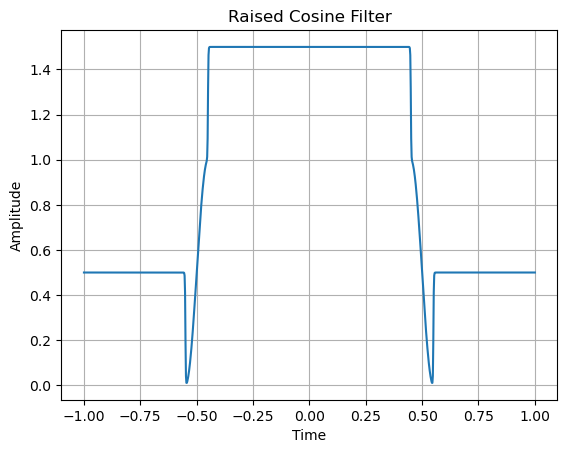

In [1]:
import sys
import os
from tqdm import tqdm
import importlib
import time
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim_func
import torch
import torch.nn
from torch.optim.lr_scheduler import LambdaLR
from pytorch_msssim import ssim
from modules import models
from modules import utils

In [2]:
nonlin = 'wire'            # type of nonlinearity, 'wire', 'siren', 'mfn', 'relu', 'posenc', 'gauss'
niters = 2000               # Number of SGD iterations
learning_rate = 5e-3        # Learning rate. 

    # WIRE works best at 5e-3 to 2e-2, Gauss and SIREN at 1e-3 - 2e-3,
# MFN at 1e-2 - 5e-2, and positional encoding at 5e-4 to 1e-3 

tau = 3e1                   # Photon noise (max. mean lambda). Set to 3e7 for representation, 3e1 for denoising
noise_snr = 2               # Readout noise (dB)

# Gabor filter constants.
# We suggest omega0 = 4 and sigma0 = 4 for denoising, and omega0=20, sigma0=30 for image representation
omega0 = 4.0           # Frequency of sinusoid
sigma0 = 4.0           # Sigma of Gaussian

# Network parameters
hidden_layers = 4       # Number of hidden layers in the MLP
hidden_features = 256   # Number of hidden units per layer
maxpoints = 256*256     # Batch size


In [3]:
# Read image and scale. A scale of 0.5 for parrot image ensures that it
# fits in a 12GB GPU
im = utils.normalize(plt.imread('images/parrot.png').astype(np.float32), True)
im = cv2.resize(im, None, fx=1/2, fy=1/2, interpolation=cv2.INTER_AREA)
H, W, _ = im.shape

In [4]:
# Create a noisy image
im_noisy = utils.measure(im, noise_snr, tau)

In [5]:
if nonlin == 'posenc':
    nonlin = 'relu'
    posencode = True
    
    if tau < 100:
        sidelength = int(max(H, W)/3)
    else:
        sidelength = int(max(H, W))
        
else:
    posencode = False
    sidelength = H

In [6]:
model = models.get_INR(
                    nonlin=nonlin,
                    in_features=2,
                    out_features=3, 
                    hidden_features=hidden_features,
                    hidden_layers=hidden_layers,
                    first_omega_0=omega0,
                    hidden_omega_0=omega0,
                    scale=sigma0,
                    pos_encode=posencode,
                    sidelength=sidelength)
        
    # Send model to CUDA
model.cuda()

print('Number of parameters: ', utils.count_parameters(model))
print('Input PSNR: %.2f dB'%utils.psnr(im, im_noisy))

Number of parameters:  132857
Input PSNR: 17.65 dB


In [7]:
# Create an optimizer
optim = torch.optim.Adam(lr=learning_rate*min(1, maxpoints/(H*W)),
                         params=model.parameters())

# Schedule to reduce lr to 0.1 times the initial rate in final epoch
scheduler = LambdaLR(optim, lambda x: 0.1**min(x/niters, 1))

In [8]:
x = torch.linspace(-1, 1, W)
y = torch.linspace(-1, 1, H)

X, Y = torch.meshgrid(x, y, indexing='xy')
coords = torch.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))[None, ...]

gt = torch.tensor(im).cuda().reshape(H*W, 3)[None, ...]
gt_noisy = torch.tensor(im_noisy).cuda().reshape(H*W, 3)[None, ...]

mse_array = torch.zeros(niters, device='cuda')
mse_loss_array = torch.zeros(niters, device='cuda')
time_array = torch.zeros_like(mse_array)

best_mse = torch.tensor(float('inf'))
best_img = None

rec = torch.zeros_like(gt)

init_time = time.time()

In [9]:
tbar = tqdm(range(niters))
# -------------------------------- Training Loop ---------------------------------
for epoch in tbar:
    indices = torch.randperm(H*W)
    
    for b_idx in range(0, H*W, maxpoints):
        b_indices = indices[b_idx:min(H*W, b_idx+maxpoints)]
        b_coords = coords[:, b_indices, ...].cuda()
        b_indices = b_indices.cuda()
        pixelvalues = model(b_coords)
        
        with torch.no_grad():
            rec[:, b_indices, :] = pixelvalues

        loss = ((pixelvalues - gt_noisy[:, b_indices, :])**2).mean() 
        
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    time_array[epoch] = time.time() - init_time
    
    with torch.no_grad():
        mse_loss_array[epoch] = ((gt_noisy - rec)**2).mean().item()
        mse_array[epoch] = ((gt - rec)**2).mean().item()
        im_gt = gt.reshape(H, W, 3).permute(2, 0, 1)[None, ...]
        im_rec = rec.reshape(H, W, 3).permute(2, 0, 1)[None, ...]
    
        psnrval = -10*torch.log10(mse_array[epoch])
        tbar.set_description('%.1f'%psnrval)
        tbar.refresh()
    
    scheduler.step()
    
    imrec = rec[0, ...].reshape(H, W, 3).detach().cpu().numpy()
        
    # cv2.imshow('Reconstruction', imrec[..., ::-1])            
    # cv2.waitKey(1)

    if (mse_array[epoch] < best_mse) or (epoch == 0):
        best_mse = mse_array[epoch]
        best_img = imrec

if posencode:
    nonlin = 'posenc'
    
mdict = {'rec': best_img,
         'gt': im,
         'im_noisy': im_noisy,
         'mse_noisy_array': mse_loss_array.detach().cpu().numpy(), 
         'mse_array': mse_array.detach().cpu().numpy(),
         'time_array': time_array.detach().cpu().numpy()}

os.makedirs('results/denoising', exist_ok=True)
io.savemat('results/denoising/%s.mat'%nonlin, mdict)

print('Best PSNR: %.2f dB'%utils.psnr(im, best_img))

26.2:   4%|▎         | 70/2000 [01:37<44:52,  1.40s/it]


KeyboardInterrupt: 

In [ ]:
best_img = mdict['best_img']
plt.imshow(best_img)
plt.title('Best Image')
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
best_img.shape
plt.imsave('best_image.png', best_img)

In [ ]:
mdict